# Cumprimento das atividades do primeiro notebook conforme tasks/CP1.txt

1. O Scraping já está feito, conforme código da aula 20250822, contemplando os 250 filmes.

OBS. A) Não incluiremos a concatenação com outra base, dado que poderíamos somar mais de 250 filmes, e adaptaremos o código para lidar com as colunas do scraping.

OBS. B) Os dados do scraping, diferente dos dados utilizados no notebook original, contemplam mais de um gênero por filme. Notamos que é o primeiro gênero em cada linha que sempre coincide com o que jazia nos dados da análise original e por isso excluiremos os subsequentes para tornar possível a imputação de um gênero por filme, necessária para rodar o notebook original. É uma medida extremamente enviesada e precária, porque um filme pode ser de Ação e de Comédia ao mesmo tempo, mas ser classificado na análise somente como de Ação. Mas seguiremos deste modo porque de outro forma teríamos de começar uma análise distinta da requisitada nas tasks, e pensamos que isso poderia trazer desvio na nota dada certa expectativa do docente nas correções.

2. 'k' igualmente já está setado como 5.

3. Rodaremos as células e com base na sua análise escreveremos os comentários finais.

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Web Scraping / Crawler

In [3]:
import requests
import re
import json
import pandas as pd

# url = "https://www.imdb.com/chart/top/"
url = "https://www.imdb.com/pt/chart/top/?ref_=nv_mv_250"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)

# Extrair JSON do script
match = re.search(r'<script id="__NEXT_DATA__" type="application/json">(.+?)</script>', response.text)
data = json.loads(match.group(1))

movies = data["props"]["pageProps"]["pageData"]["chartTitles"]["edges"]

# Montar lista de dicionários
rows = []
for m in movies:
    node = m["node"]

    title = node["titleText"]["text"]
    year = node["releaseYear"]["year"] if node.get("releaseYear") else None
    rating = node["ratingsSummary"]["aggregateRating"]
    genres = ", ".join([g["genre"]["text"] for g in node["titleGenres"]["genres"]]) if node.get("titleGenres") else None
    synopsis = node["plot"]["plotText"]["plainText"] if node.get("plot") and node["plot"].get("plotText") else None

    rows.append({
        "title": title,
        "year": year,
        "rating": rating,
        "genre": genres,
        "sinopse": synopsis
    })

# Criar DataFrame
df = pd.DataFrame(rows)
df.to_csv("data/imdb_top250.csv", index=False)
df




title  year  rating                       genre  \
0             Um Sonho de Liberdade  1994     9.3                       Drama   
1                 O Poderoso Chefão  1972     9.2             Policial, Drama   
2    Batman: O Cavaleiro das Trevas  2008     9.1       Ação, Policial, Drama   
3       O Poderoso Chefão: Parte II  1974     9.0             Policial, Drama   
4          12 Homens e uma Sentença  1957     9.0             Policial, Drama   
..                              ...   ...     ...                         ...   
245            Gangues de Wasseypur  2012     8.2     Ação, Comédia, Policial   
246            Na Natureza Selvagem  2007     8.0  Aventura, Biografia, Drama   
247              Histórias Cruzadas  2011     8.1                       Drama   
248                  Troca Surpresa  2023     8.3              Comédia, Drama   
249                     A Chantagem  2015     8.2   Policial, Drama, Mistério   

                                               sinopse  
0    Dois homens presos se reúnem ao longo de vário...  
1    O patriarca idoso de uma dinastia do crime org...  
2    Agora com a ajuda do tenente Jim Gordon e do p...  
3    O início da vida e da carreira de Vito Corleon...  
4    O julgamento de um assassinato em Nova Iorque ...  
..                                                 ...  
245  Um confronto entre Sultão e Shahid Khan leva à...  
246  Depois de terminar a universidade, Christopher...  
247  Uma aspirante a escritora durante o movimento ...  
248  Trocadas por acidente enquanto viajavam até a ...  
249  Um homem toma medidas desesperadas para tentar...  

[250 rows x 5 columns]

In [4]:
df["genre"] = df["genre"].str.split(",").str[0].str.strip()


In [5]:
df


title  year  rating     genre  \
0             Um Sonho de Liberdade  1994     9.3     Drama   
1                 O Poderoso Chefão  1972     9.2  Policial   
2    Batman: O Cavaleiro das Trevas  2008     9.1      Ação   
3       O Poderoso Chefão: Parte II  1974     9.0  Policial   
4          12 Homens e uma Sentença  1957     9.0  Policial   
..                              ...   ...     ...       ...   
245            Gangues de Wasseypur  2012     8.2      Ação   
246            Na Natureza Selvagem  2007     8.0  Aventura   
247              Histórias Cruzadas  2011     8.1     Drama   
248                  Troca Surpresa  2023     8.3   Comédia   
249                     A Chantagem  2015     8.2  Policial   

                                               sinopse  
0    Dois homens presos se reúnem ao longo de vário...  
1    O patriarca idoso de uma dinastia do crime org...  
2    Agora com a ajuda do tenente Jim Gordon e do p...  
3    O início da vida e da carreira de Vito Corleon...  
4    O julgamento de um assassinato em Nova Iorque ...  
..                                                 ...  
245  Um confronto entre Sultão e Shahid Khan leva à...  
246  Depois de terminar a universidade, Christopher...  
247  Uma aspirante a escritora durante o movimento ...  
248  Trocadas por acidente enquanto viajavam até a ...  
249  Um homem toma medidas desesperadas para tentar...  

[250 rows x 5 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    250 non-null    object 
 1   year     250 non-null    int64  
 2   rating   250 non-null    float64
 3   genre    250 non-null    object 
 4   sinopse  250 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 9.9+ KB


In [7]:
# Adjusting variable types
df['year'] = df['year'].astype('float64')
df['rating'] = df['rating'].astype('float64')

In [8]:
df.describe()

year      rating
count   250.000000  250.000000
mean   1988.652000    8.309600
std      25.467573    0.231261
min    1921.000000    8.000000
25%    1973.000000    8.100000
50%    1995.500000    8.200000
75%    2009.000000    8.400000
max    2024.000000    9.300000

## Plots

In [9]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

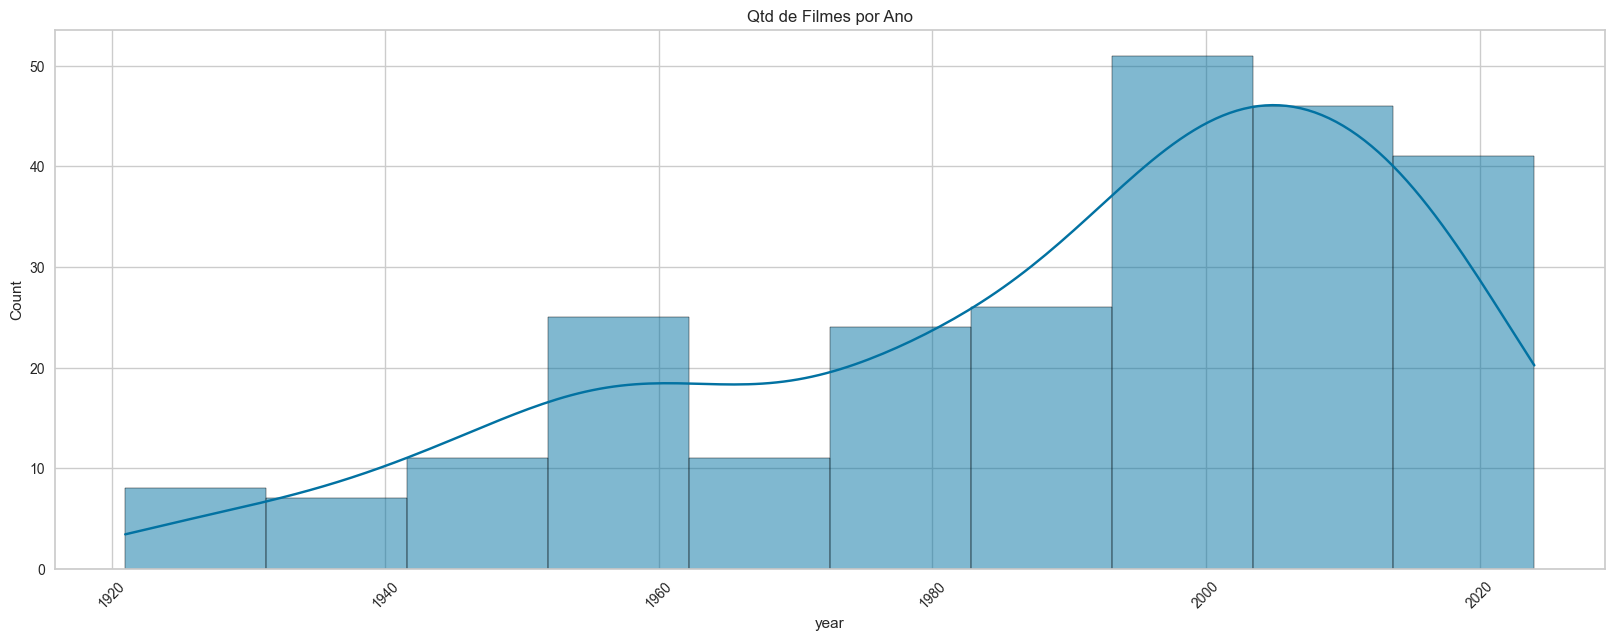

In [10]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

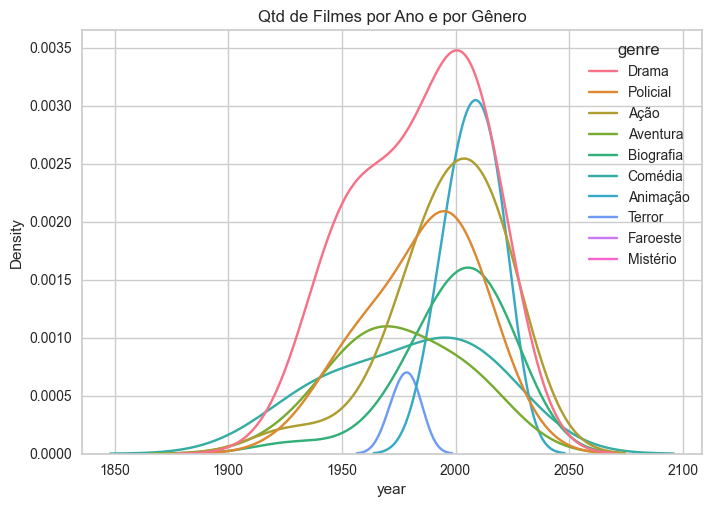

In [11]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [12]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

0    dois homens presos se reúnem ao longo de vário...
1    o patriarca idoso de uma dinastia do crime org...
2    agora com a ajuda do tenente jim gordon e do p...
3    o início da vida e da carreira de vito corleon...
4    o julgamento de um assassinato em nova iorque ...
Name: sinopse, dtype: object

In [13]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [14]:
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

title    year  rating     genre  \
0           Um Sonho de Liberdade  1994.0     9.3     Drama   
1               O Poderoso Chefão  1972.0     9.2  Policial   
2  Batman: O Cavaleiro das Trevas  2008.0     9.1      Ação   
3     O Poderoso Chefão: Parte II  1974.0     9.0  Policial   
4        12 Homens e uma Sentença  1957.0     9.0  Policial   

                                             sinopse  word_count  
0  dois homens presos se reúnem ao longo de vário...          21  
1  o patriarca idoso de uma dinastia do crime org...          20  
2  agora com a ajuda do tenente jim gordon e do p...          45  
3  o início da vida e da carreira de vito corleon...          31  
4  o julgamento de um assassinato em nova iorque ...          29

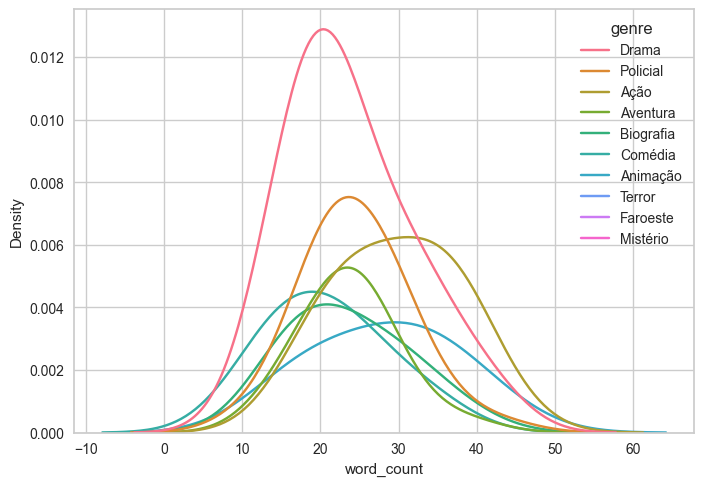

In [15]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover stopwords

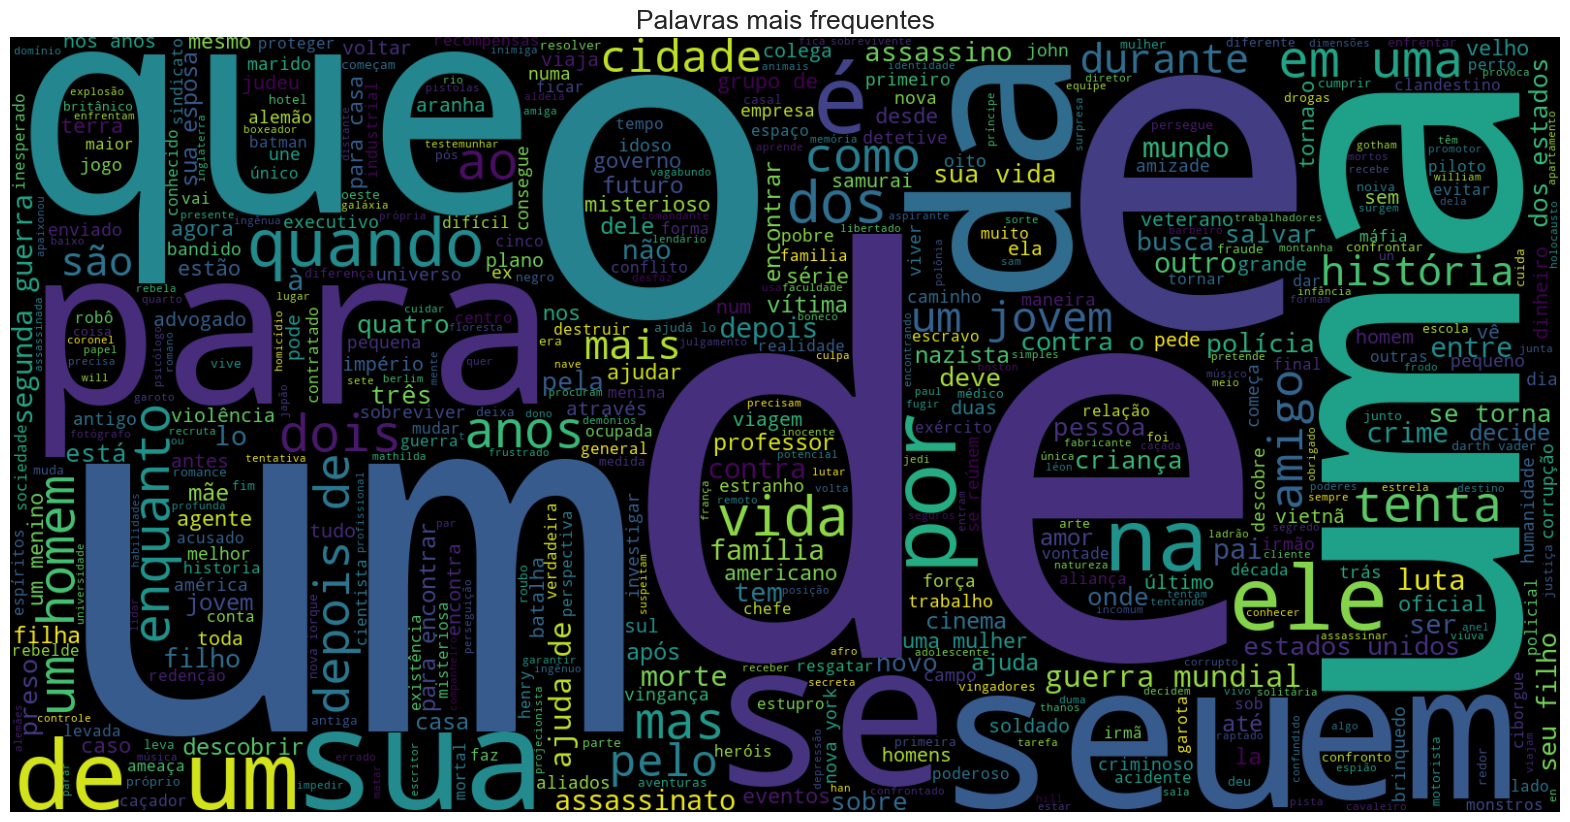

In [16]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [17]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


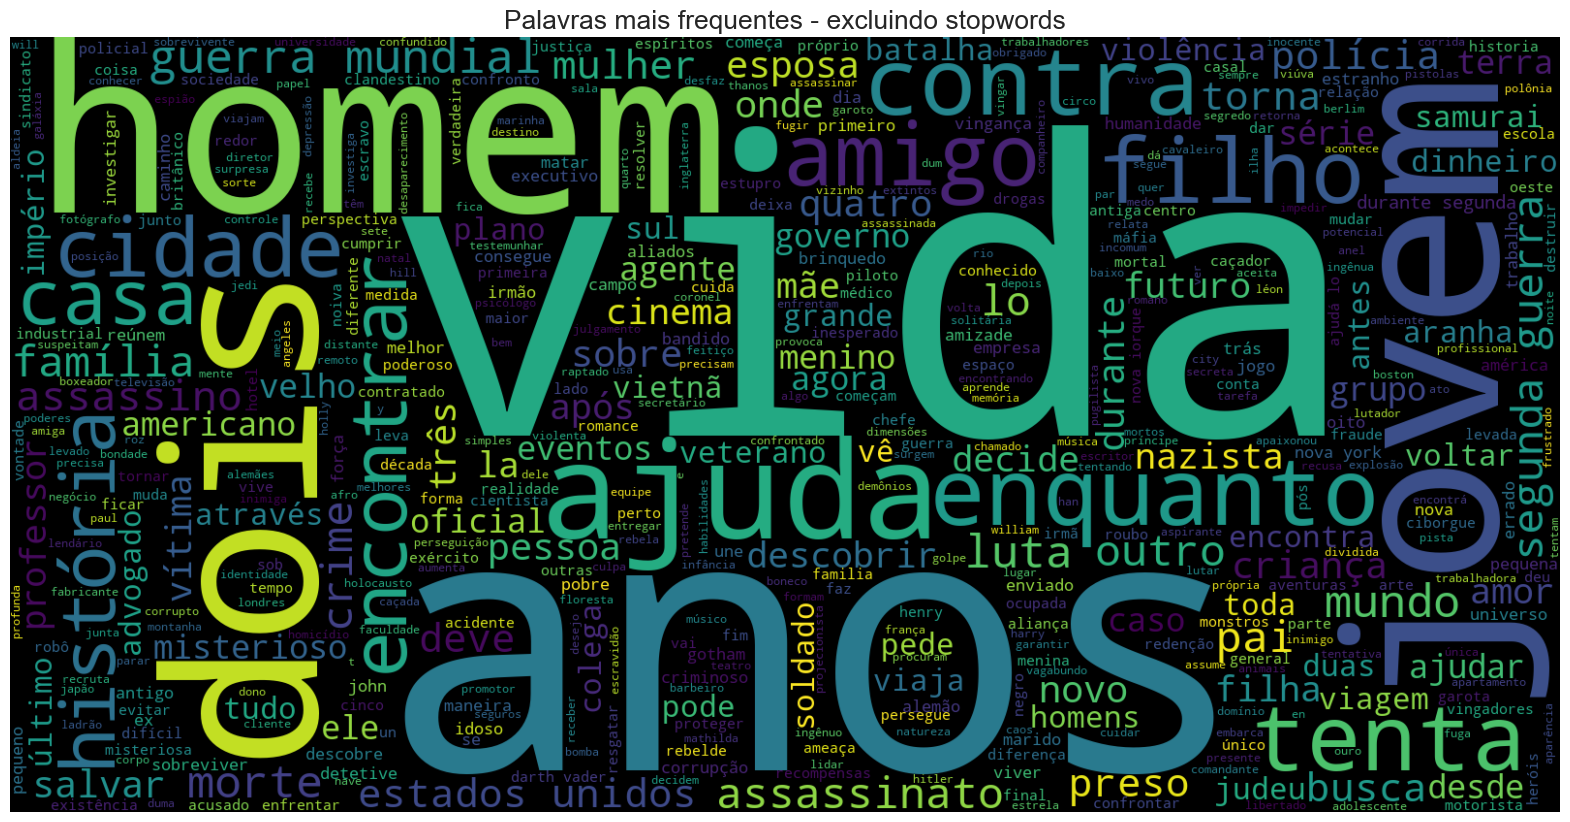

In [18]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF

In [19]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [20]:
print(X.shape)
X.toarray()

(250, 16)


array([[0.        , 0.69797708, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.65261053, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.74489556, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(250, 16))

# KMeans - Clusterização

## Escolhendo o numero de "k" clusters ideal

### Método Elbow

In [21]:
df_processed

title    year  rating     genre  \
0             Um Sonho de Liberdade  1994.0     9.3     Drama   
1                 O Poderoso Chefão  1972.0     9.2  Policial   
2    Batman: O Cavaleiro das Trevas  2008.0     9.1      Ação   
3       O Poderoso Chefão: Parte II  1974.0     9.0  Policial   
4          12 Homens e uma Sentença  1957.0     9.0  Policial   
..                              ...     ...     ...       ...   
245            Gangues de Wasseypur  2012.0     8.2      Ação   
246            Na Natureza Selvagem  2007.0     8.0  Aventura   
247              Histórias Cruzadas  2011.0     8.1     Drama   
248                  Troca Surpresa  2023.0     8.3   Comédia   
249                     A Chantagem  2015.0     8.2  Policial   

                                               sinopse  word_count  \
0    dois homens presos se reúnem ao longo de vário...          21   
1    o patriarca idoso de uma dinastia do crime org...          20   
2    agora com a ajuda do tenente jim gordon e do p...          45   
3    o início da vida e da carreira de vito corleon...          31   
4    o julgamento de um assassinato em nova iorque ...          29   
..                                                 ...         ...   
245  um confronto entre sultão e shahid khan leva à...          25   
246  depois de terminar a universidade, christopher...          20   
247  uma aspirante a escritora durante o movimento ...          32   
248  trocadas por acidente enquanto viajavam até a ...          17   
249  um homem toma medidas desesperadas para tentar...          22   

                                  sinopse_no_stopwords  
0    dois homens presos reúnem longo vários anos, e...  
1    patriarca idoso dinastia crime organizado tran...  
2    agora ajuda tenente jim gordon promotor públic...  
3    início vida carreira vito corleone década 1920...  
4    julgamento assassinato nova iorque frustrado ú...  
..                                                 ...  
245  confronto sultão shahid khan leva expulsão kha...  
246  terminar universidade, christopher mccandless ...  
247  aspirante escritora durante movimento direitos...  
248  trocadas acidente enquanto viajavam casa novos...  
249  homem toma medidas desesperadas tentar salvar ...  

[250 rows x 7 columns]

2 140.79857240158336
3 129.3613779294748
4 118.11095197882882
5 105.91999281032032
6 95.64975604563995
7 86.9633475593611
8 78.96151158262066
9 66.34012054556214
10 65.0709293740121


Text(0, 0.5, 'WCSS')

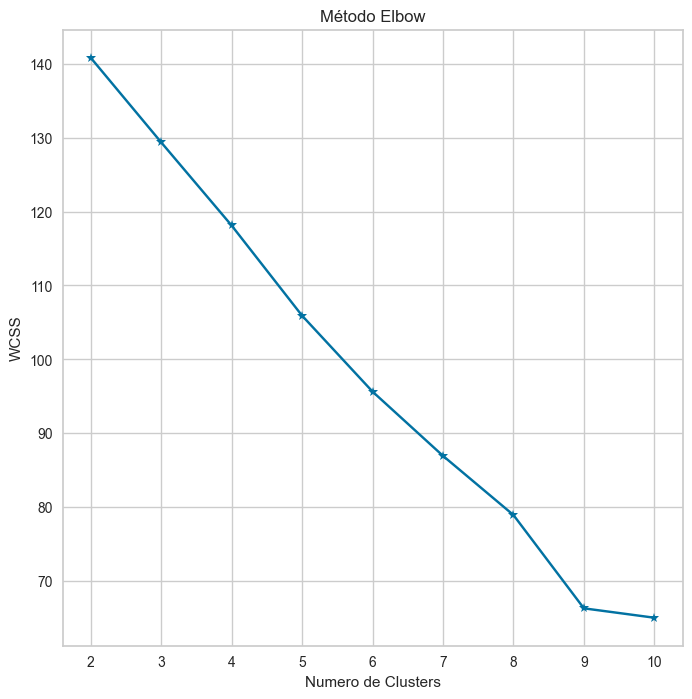

In [22]:
plt.figure(figsize = (8,8))

#plotando o grafico do método elbow
wcss = []

for i in range(2, df_processed.genre.nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df_processed.genre.nunique()+1), wcss, '*-')
plt.title('Método Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS') #within cluster sum of square


### Método Silhouette

In [23]:
df_processed.genre.nunique()

10

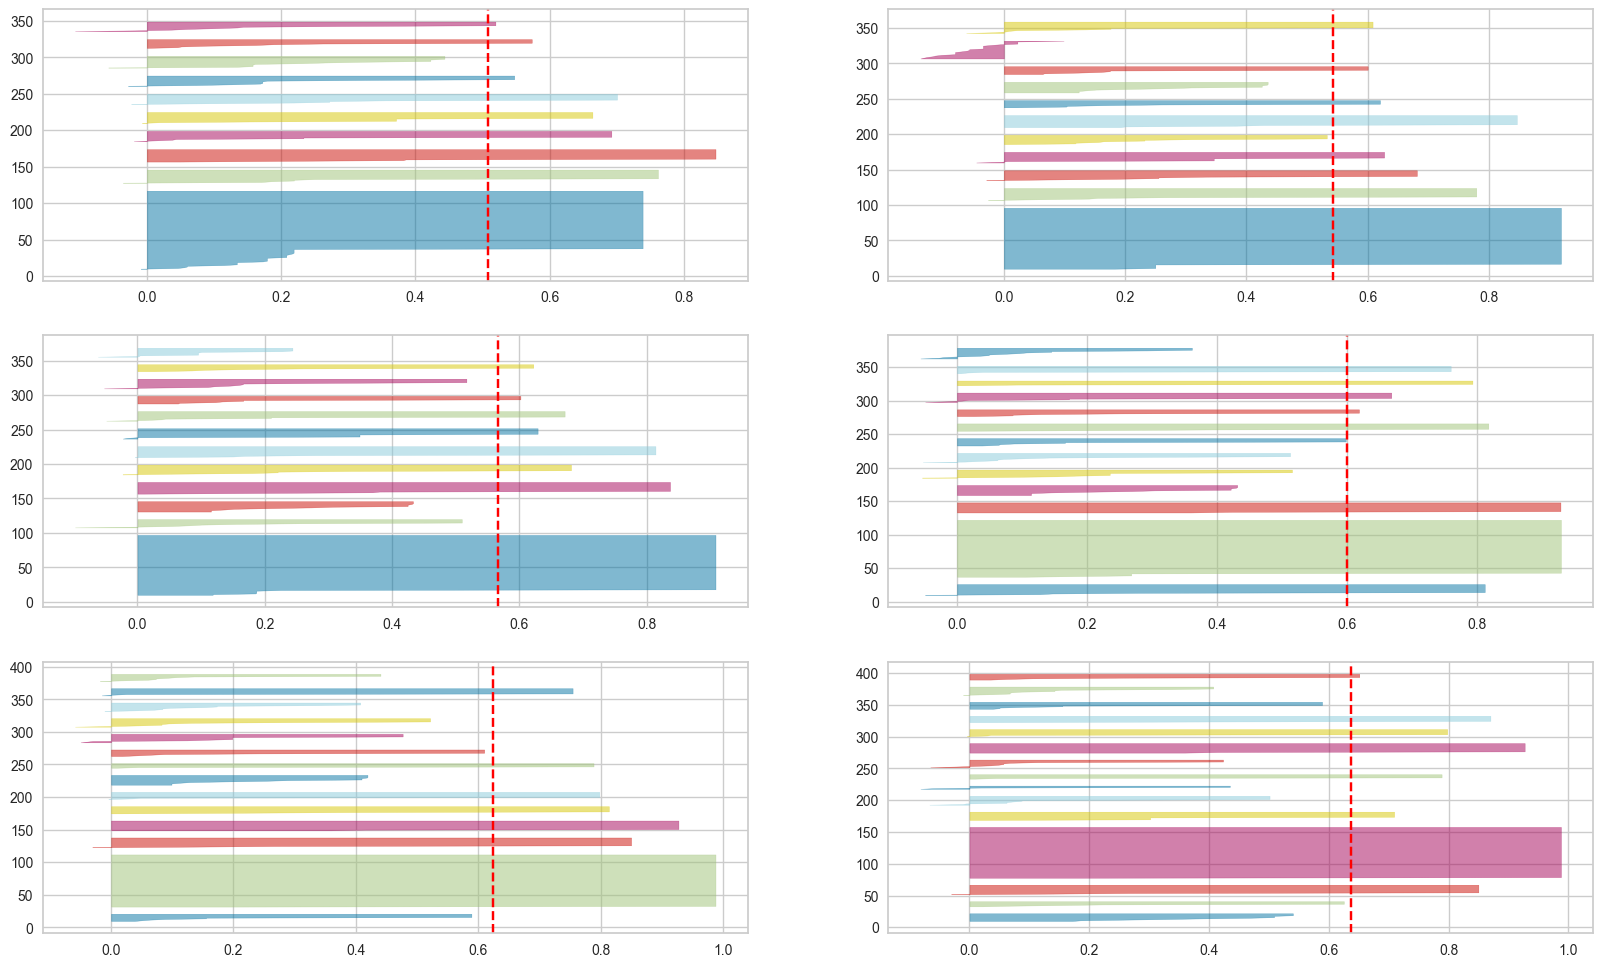

In [24]:
# fig, ax = plt.subplots(3,2, figsize = (20,12))
# for i in (range(10, 17)):
#   #Creating KMeans instance for different number of clusters
#   kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
#   q, mod = divmod(i,2)

#   #Creating SilhouetteVisualizer instance with KMeans instance
#   #Fit the visualizer

#   visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
#   visualizer.fit(X)

fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = i + 10, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

### Análise do número de clusters
* O método de elbow indicou um numero de k ideal entre 10 e 15. Pelo método de Silhouete não ficou muito claro, mas para k acima de 12 o aumento no valor da Silhouete (eixo x) é pequeno a cada k. Para efeitos didáticos, será adotado k=5 para facilitar as análises, mas em um projeto real deve ser testado o numero de k indicado pelos 2 métodos.

# Comparativo entre os 5 clusters

In [25]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans = kmeans.fit(X)
#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)
#getting the cluster centers
c = kmeans.cluster_centers_

df_processed['cluster'] = labels
df_processed.head()

title    year  rating     genre  \
0           Um Sonho de Liberdade  1994.0     9.3     Drama   
1               O Poderoso Chefão  1972.0     9.2  Policial   
2  Batman: O Cavaleiro das Trevas  2008.0     9.1      Ação   
3     O Poderoso Chefão: Parte II  1974.0     9.0  Policial   
4        12 Homens e uma Sentença  1957.0     9.0  Policial   

                                             sinopse  word_count  \
0  dois homens presos se reúnem ao longo de vário...          21   
1  o patriarca idoso de uma dinastia do crime org...          20   
2  agora com a ajuda do tenente jim gordon e do p...          45   
3  o início da vida e da carreira de vito corleon...          31   
4  o julgamento de um assassinato em nova iorque ...          29   

                                sinopse_no_stopwords  cluster  
0  dois homens presos reúnem longo vários anos, e...        4  
1  patriarca idoso dinastia crime organizado tran...        1  
2  agora ajuda tenente jim gordon promotor públic...        1  
3  início vida carreira vito corleone década 1920...        0  
4  julgamento assassinato nova iorque frustrado ú...        1

## Filmes por cluster

In [26]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros por Cluster

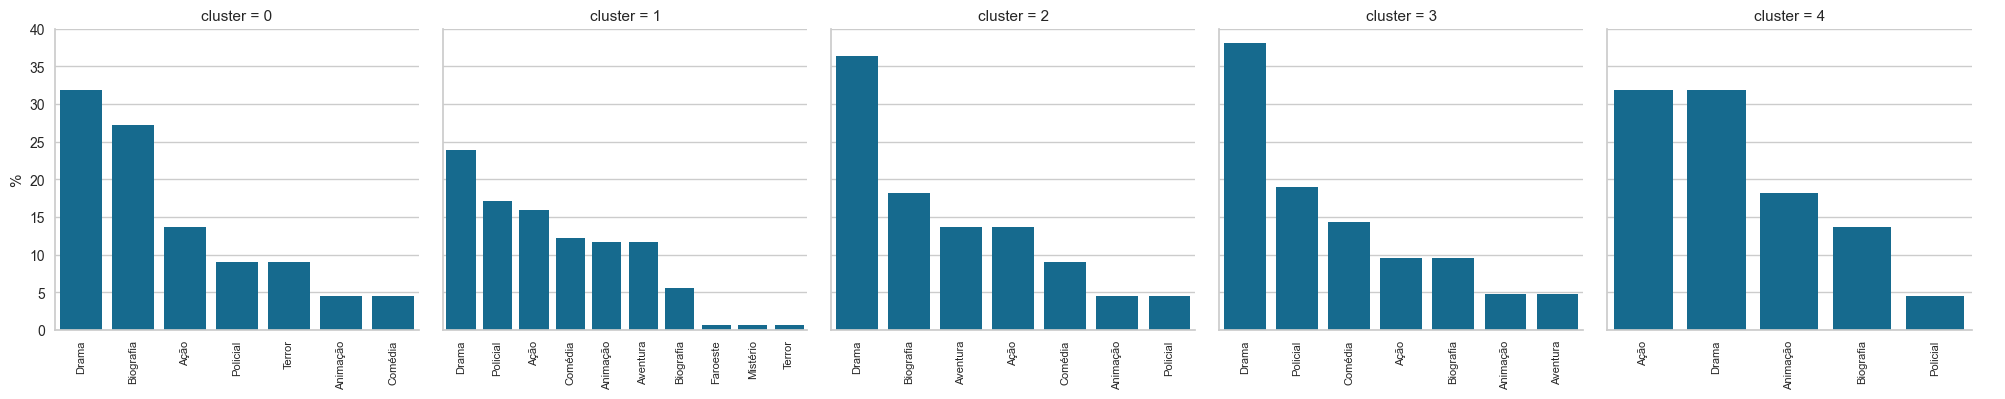

In [27]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

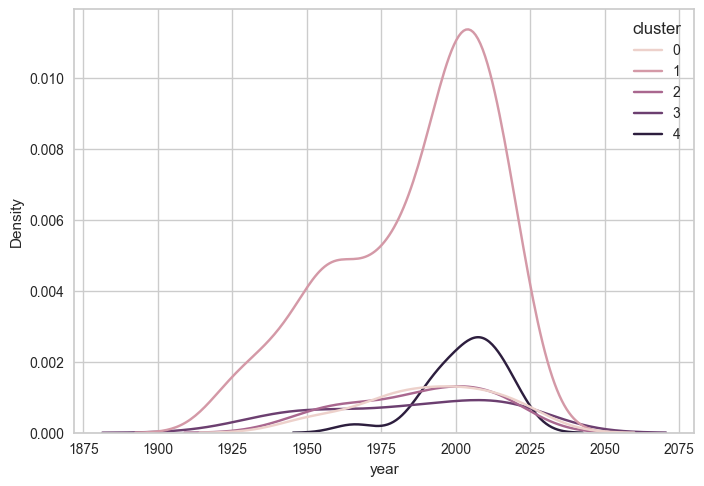

In [28]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [32]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'genre', columns = 'cluster', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

genre  cluster   Animação   Aventura       Ação  Biografia    Comédia  \
0            0   4.545455   0.000000  13.636364  27.272727   4.545455   
1            1  11.656442  11.656442  15.950920   5.521472  12.269939   
2            2   4.545455  13.636364  13.636364  18.181818   9.090909   
3            3   4.761905   4.761905   9.523810   9.523810  14.285714   
4            4  18.181818   0.000000  31.818182  13.636364   0.000000   

genre      Drama  Faroeste  Mistério   Policial    Terror  
0      31.818182  0.000000  0.000000   9.090909  9.090909  
1      23.926380  0.613497  0.613497  17.177914  0.613497  
2      36.363636  0.000000  0.000000   4.545455  0.000000  
3      38.095238  0.000000  0.000000  19.047619  0.000000  
4      31.818182  0.000000  0.000000   4.545455  0.000000

In [ ]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

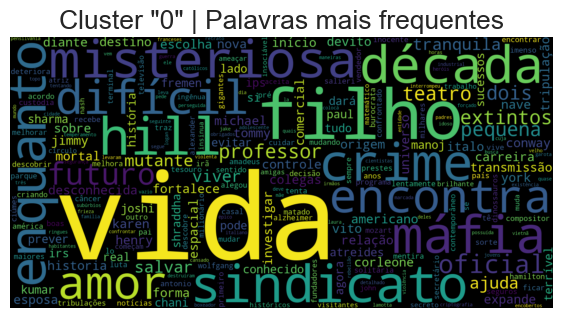

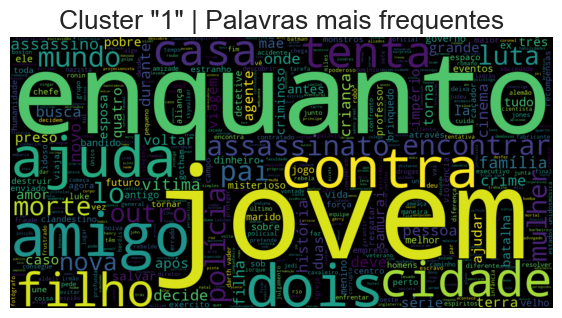

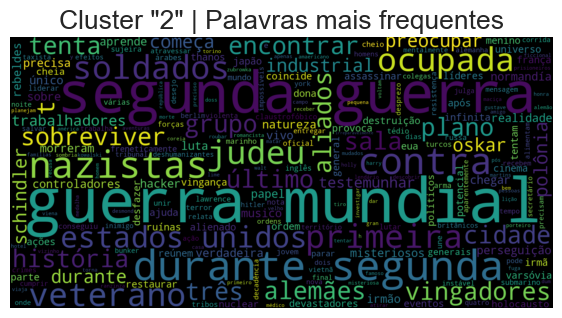

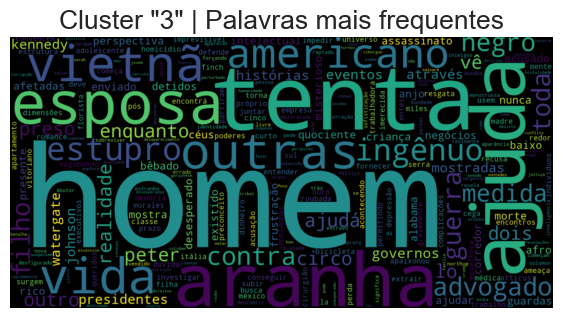

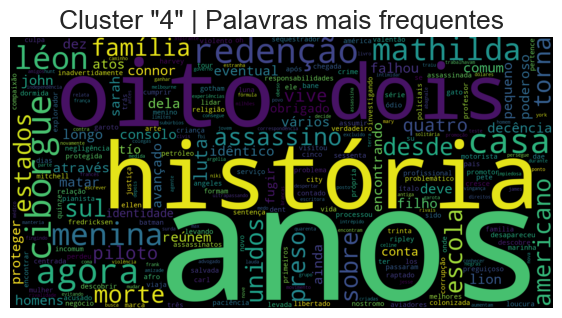

In [ ]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# Considerações Finais

Em primeiro lugar, como advertido na introdução, passaremos por alto quanto ao fato de que a atribuição de gêneros aos filmes não corresponde com sua distribuição real, podendo haver mais representantes de vários gêneros do que consta no presente notebook, e seguiremos com a análise na suposição hipotética de que cada filme pertence a um único gênero.

## 1) Balanceamento

Passando à análise, a primeira observação importante é que *o cluster 1 apresentou um número de amostras 8 vezes superior ao dos demais clusters*, cada qual contando apenas com em torno de 20 amostras. Isto somente já é o sufience para inferir que ou as features ou o número de k muito provalemente não encontram-se na sua configuração ótima, pois quando um único cluster absorve quase a totalidade das amostras, não se trata de uma evidência de homogeneidade real, mas antes de um indício de que a granularidade da partição não se ajusta ao relevo efetivo do espaço de atributos.

## 2) Distribuição dos gêneros

Cluster 0

Forte presença de Drama (31,8%) e Biografia (27,2%).
Perfil mais sério, voltado a narrativas realistas.

Cluster 1

Distribuição mais equilibrada entre Ação, Aventura, Comédia, Policial (10–17%).
Representa um conjunto diversificado, sem gênero dominante.

Cluster 2

Predomínio de Drama (36,3%) e Biografia (18,1%), com Ação relevante (13,6%).
Similar ao cluster 0, mas com drama ainda mais central.

Cluster 3

Drama (38,1%) como eixo principal, seguido de Policial (19%) e Comédia (14,2%).
Mistura entre tensão narrativa e elementos de humor.

Cluster 4

Ação (31,8%) e Drama (31,8%) em equilíbrio.
Perfil orientado a tramas de alto impacto emocional e dinamismo.


Os agrupamentos não apresentam divisões claras entre gêneros, mas antes uma sobreposição, em especial pelo protagonismo constante do Drama em praticamente todos os clusters. A hipótese mais plausível é que a utilização das sinopses como feature de treino não privilegia os marcadores formais de gênero, mas sim recorrências temáticas. Com isso, o algoritmo termina por produzir clusters que refletem variações de tom ou atmosfera (realismo, tensão, humor, dinamismo), mas não categorias de gênero propriamente ditas.

## 3) Distribuição temporal

Constatou-se que também não há diferenças significativas entre os agrupamentos com relação aos anos de lançamento, sendo todos marcados por uma concentração predominante ao redor do ano 2000. Essa homogeneidade temporal reforça a percepção de que a clusterização não está captando dimensões estruturais de diferenciação entre os filmes.

## 4) Nuvens de palavras

A análise das palavras mais frequentes em cada cluster revela padrões temáticos distintos, mas novamente evidencia a ausência de divisões claras entre gêneros cinematográficos.

Cluster 0 evidencia termos relacionados à vida cotidiana e relações familiares, como vida, filho, amor, sugerindo um perfil narrativo voltado para dramas pessoais ou biográficos.

Cluster 1 apresenta palavras como jovem, luta, cidade e assassinato, indicando narrativas mais centradas em conflitos urbanos e desafios de personagens em crescimento ou em confronto com o ambiente.

Cluster 2 é fortemente marcado por vocabulário ligado a guerras e conflitos históricos, com destaque para guerra, segunda, mundial, soldados e nazistas, apontando para filmes com temáticas bélicas ou históricas.

Cluster 3 traz termos como homem, tenta, ajuda e advogado, misturando elementos de ação, drama pessoal e até referências pontuais a filmes de super-heróis (homem-aranha), indicando uma heterogeneidade temática significativa.

Cluster 4 apresenta palavras temporais e narrativas de crescimento ou eventos marcantes, como anos, história, menina e morte, sugerindo histórias com foco em trajetórias de vida e contextos históricos ou sociais.

Em suma, as nuvens de palavras confirmam a percepção obtida nas seções anteriores: os clusters capturam mais temas e narrativas recorrentes do que distinções formais de gênero. A predominância de termos relacionados a Drama, conflitos pessoais ou históricos reforça que a clusterização não conseguiu separar de forma robusta filmes por gênero, refletindo limitações do uso das sinopses como única feature de treino.